In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataset import Dataset

from field_index import FieldIndex
from seismic_batch import SeismicBatch
from utils import get_file_by_index

In [2]:
dfr = pd.read_csv('/home/egor/Desktop/2D_Valyton/sps/ALL_VALUNT0910_R_utm.txt', sep='\s+', header=None)
dfr.columns = ['rline', 'rid', 'x', 'y', 'z']
dfr = dfr.astype({'rid': np.int32, 'x': np.float32, 'y': np.float32, 'z': np.float32})

dfs = pd.read_csv('/home/egor/Desktop/2D_Valyton/sps/ALL_VALUNT0910_S_utm.txt', sep='\s+', header=None)
dfs.columns = ['sline', 'sid', 'point_index', 'sht_depth', 'uphole', 'x', 'y', 'z']
dfs = dfs.dropna(axis=0)
dfs = dfs.astype({'sid': np.int32, 'point_index': np.int8, 'sht_depth': np.float32,
                  'uphole': np.float32, 'x': np.float32, 'y': np.float32, 'z': np.float32})

dfx = pd.read_csv('/home/egor/Desktop/2D_Valyton/sps/ALL_VALUNT0910_X.sps',
                  sep='\s+', header=None, skiprows=49)
dfx.columns = ['tape', 'xid', 'sline', 'sid', 'from_channel', 'to_channel', 'rline',
               'from_receiver', 'to_receiver']
dfx['sline'] = dfx['sline'].apply(lambda x: "S" + str(x))
dfx['rline'] = dfx['rline'].apply(lambda x: "R" + str(x))
dfx = dfx.astype({'xid': np.int32, 'sid': np.int32,
                  'from_channel': np.int16, 'to_channel': np.int16,
                  'from_receiver': np.int32, 'to_receiver': np.int32})

## Генерация батчей ОПВ сейсмограмм

In [3]:
dfx37 = dfx[dfx['sline'] == 'S37']

In [11]:
shot_index = FieldIndex(dfr=dfr, dfs=dfs, dfx=dfx37)

In [14]:
shot_set = Dataset(shot_index, SeismicBatch)

In [15]:
path = '/home/egor/Desktop/2D_Valyton/prof_37/segy/'
batch = (shot_set.next_batch(15)
        .load(path=path, fmt='segy', sort_by='channel',
              get_file_by_index=get_file_by_index, skip_channels=2)
        .to_2d())

<IPython.core.display.Javascript object>


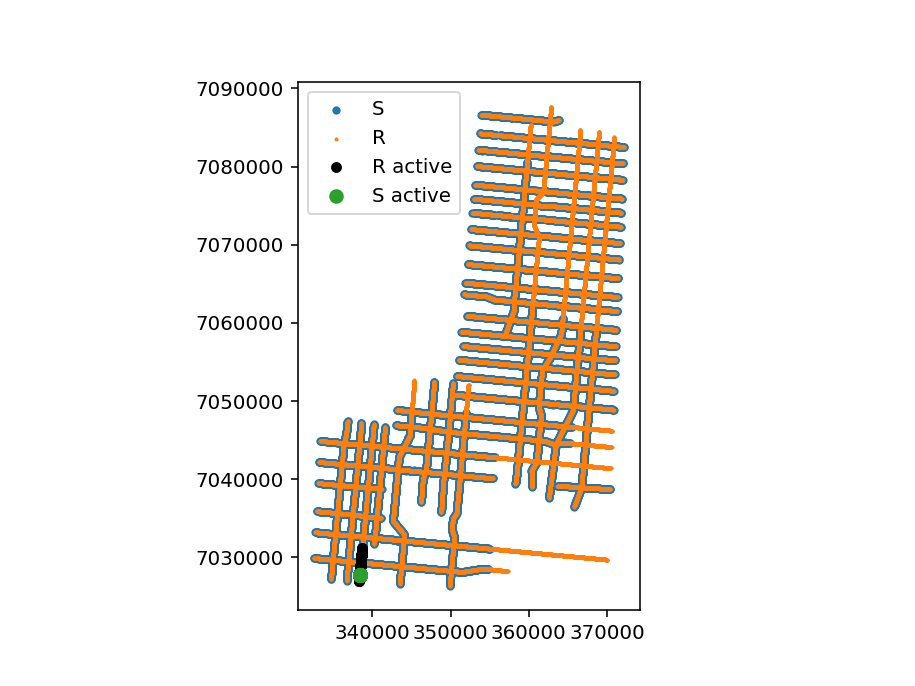

In [21]:
%matplotlib notebook

plt.scatter(dfs['x'], dfs['y'], s=10, label="S")
plt.scatter(dfr['x'], dfr['y'], s=1, label="R")

view = batch.index._idf.loc[batch.indices[14]]
plt.scatter(view['x_r'], view['y_r'], s=20, c='black', label="R active")
plt.scatter(view['x_s'], view['y_s'], s=40, label="S active")

plt.legend()
plt.axes().set_aspect('equal')
plt.show()

<IPython.core.display.Javascript object>


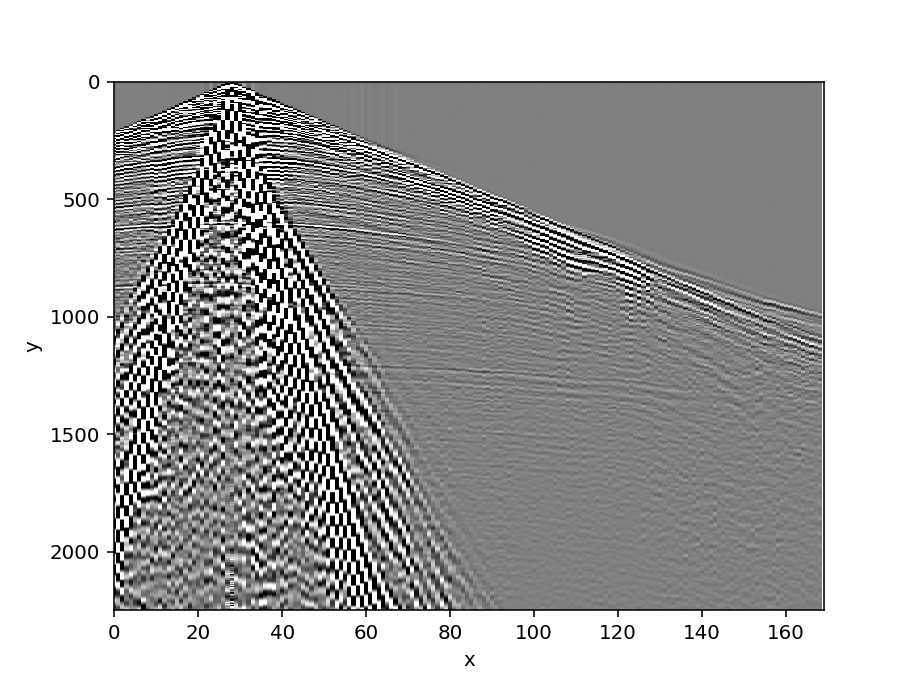

In [16]:
%matplotlib notebook
cv = 3
batch.show_slice(batch.indices[14], vmin=-cv, vmax=cv, cmap="gray")

### Пересортировка трасс

In [17]:
batch_r2 = batch.sort_traces('r2')

<IPython.core.display.Javascript object>


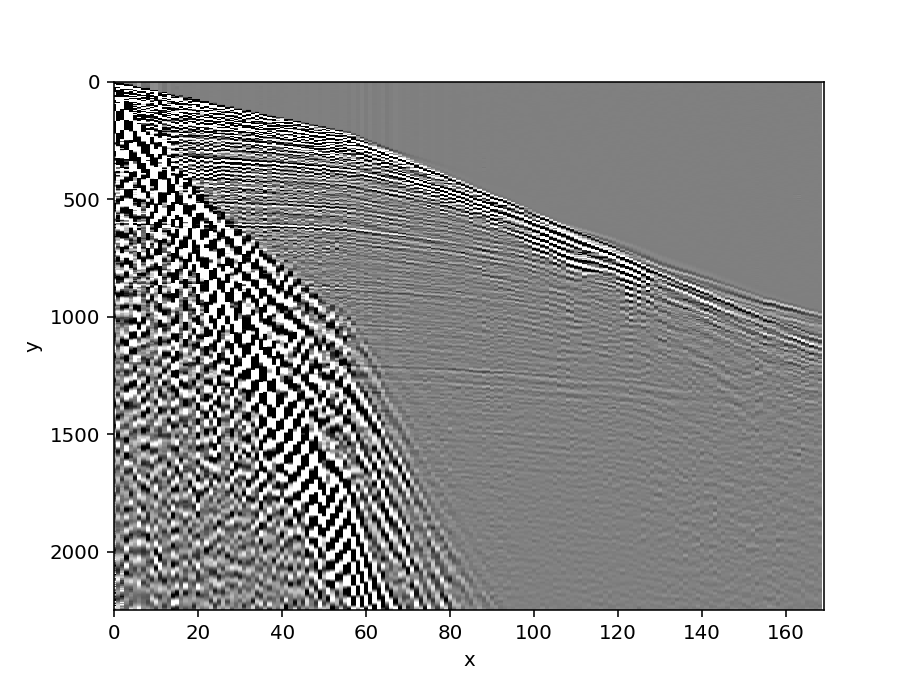

In [19]:
%matplotlib notebook
cv = 3
batch_r2.show_slice(batch.indices[14], vmin=-cv, vmax=cv, cmap="gray")

## Генерация батчей 2D ОСТ сейсмограмм

In [22]:
bin_size = 2000

mp_index = FieldIndex(dfr=dfr, dfs=dfs, dfx=dfx, bin_size=bin_size, iters=100)

<IPython.core.display.Javascript object>


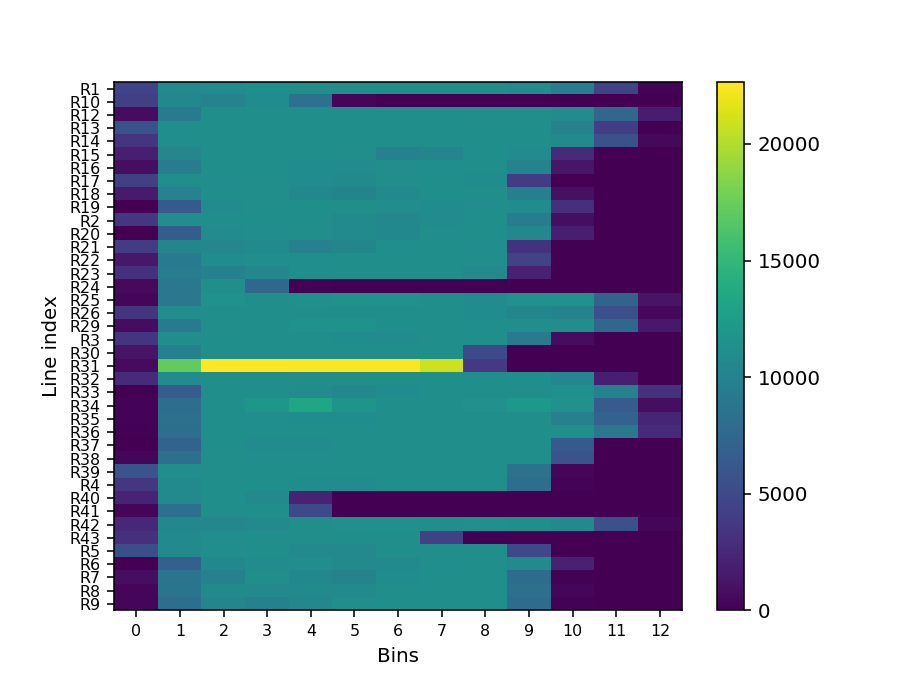

In [23]:
%matplotlib notebook

mp_index.show_heatmap()

In [24]:
fset = Dataset(mp_index, SeismicBatch)
batch = fset.next_batch(15)
print(batch.indices)

Index(['R1/1', 'R1/10', 'R1/11', 'R1/12', 'R1/13', 'R1/2', 'R1/3', 'R1/4',
       'R1/5', 'R1/6', 'R1/7', 'R1/8', 'R1/9', 'R10/1', 'R10/2'],
      dtype='object')


<IPython.core.display.Javascript object>


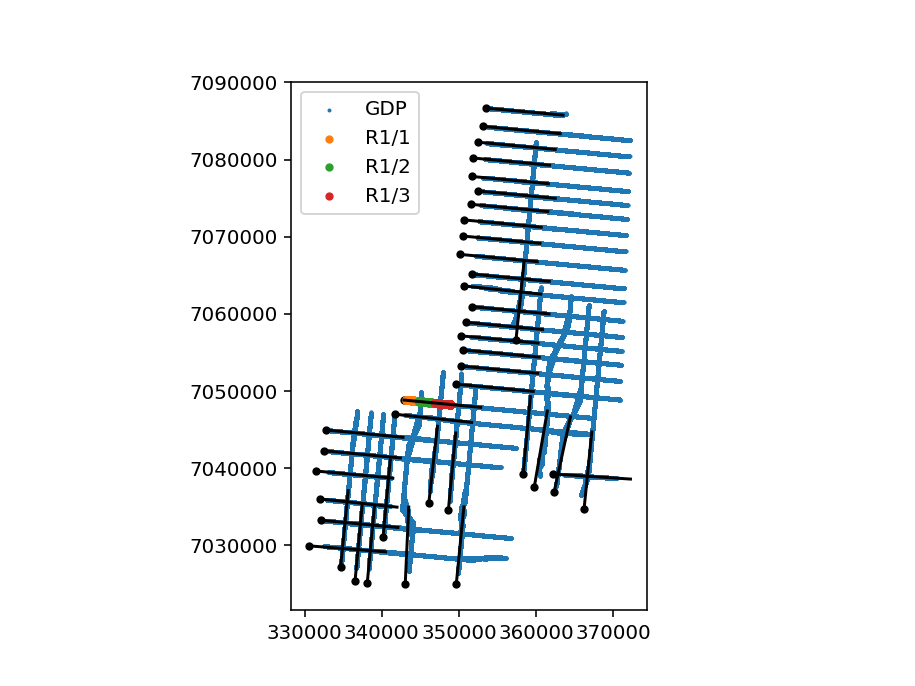

In [25]:
%matplotlib notebook

plt.scatter(mp_index._idf['x_m'], mp_index._idf['y_m'], s=1, label="GDP")

l = 10000
for k, v in mp_index.meta.items():
    if k == 'bin_size':
        continue
    phi = v['phi']
    w = l* np.array([np.cos(np.radians(phi)), np.sin(np.radians(phi))])
    plt.scatter(*v['origin'], s=10, color='black')
    plt.plot(*np.vstack([v['origin'], v['origin'] + w]).T, color='black')

view = batch.index._idf.loc['R1/1']
plt.scatter(view['x_m'], view['y_m'], s=10, label='R1/1')

view = batch.index._idf.loc['R1/2']
plt.scatter(view['x_m'], view['y_m'], s=10, label='R1/2')

view = batch.index._idf.loc['R1/3']
plt.scatter(view['x_m'], view['y_m'], s=10, label='R1/3')

plt.legend()
plt.axes().set_aspect('equal')
plt.show()

## Генерация батчей 3D ОСТ сейсмограмм

In [29]:
bin_size = 10000

mp_index_2d = FieldIndex(dfr=dfr, dfs=dfs, dfx=dfx, bin_size=(bin_size, bin_size), iters=20)

<IPython.core.display.Javascript object>


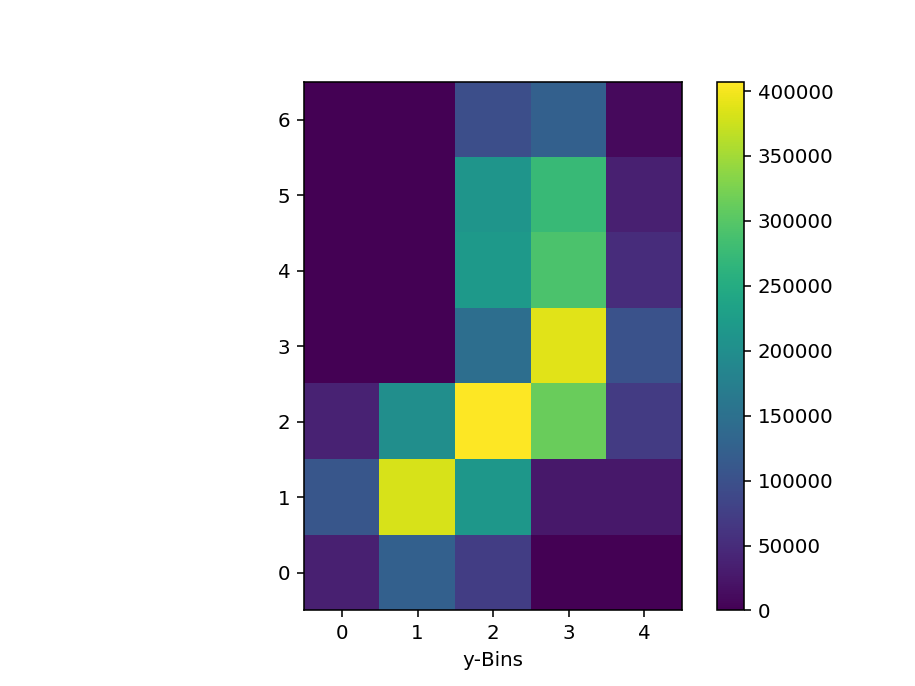

In [30]:
%matplotlib notebook

mp_index_2d.show_heatmap()

In [32]:
fset = Dataset(mp_index_2d, SeismicBatch)
batch = fset.next_batch(15)
batch.indices

Index(['1/1', '1/2', '1/3', '2/1', '2/2', '2/3', '3/1', '3/2', '3/3', '3/4',
       '3/5', '3/6', '3/7', '4/1', '4/2'],
      dtype='object')

<IPython.core.display.Javascript object>


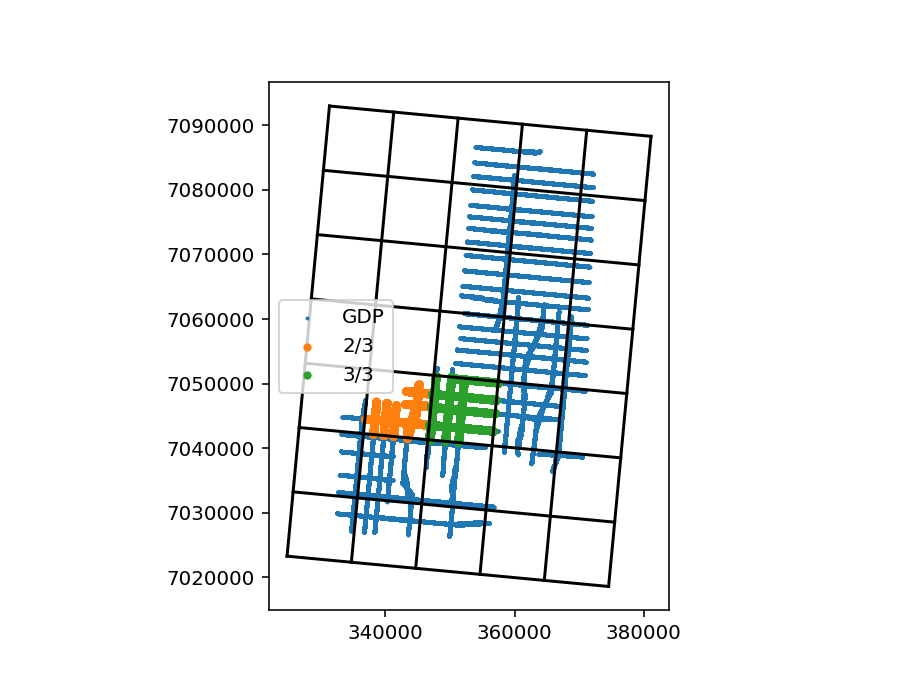

In [35]:
%matplotlib notebook

plt.scatter(mp_index_2d._idf['x_m'], mp_index_2d._idf['y_m'], s=1, label="GDP")

view = batch.index._idf.loc['2/3']
plt.scatter(view['x_m'], view['y_m'], s=10, label='2/3')

view = batch.index._idf.loc['3/3']
plt.scatter(view['x_m'], view['y_m'], s=10, label='3/3')

l = bin_size
origin = mp_index_2d.meta['origin']
vecs = np.array([[0, l], [l, 0]])
phi = np.radians(mp_index_2d.meta['phi'])
rotm = np.array([[np.cos(phi), -np.sin(phi)], [np.sin(phi), np.cos(phi)]])
vecs = np.dot(rotm, vecs.T).T

bin_counts = mp_index_2d._idf.groupby(level=[0]).size()
bins = np.array([np.array(i.split('/')).astype(int) for i in bin_counts.index])
brange = np.max(bins, axis=0)

for i in range(brange[1] + 1):
    plt.plot([origin[0] + i * vecs[0, 0], origin[0] + i * vecs[0, 0] + brange[0] * vecs[1, 0]],
             [origin[1] + i * vecs[0, 1], origin[1] + i * vecs[0, 1] + brange[0] * vecs[1, 1]], color='black')

for i in range(brange[0] + 1):
    plt.plot([origin[0] + i * vecs[1, 0], origin[0] + i * vecs[1, 0] + brange[1] * vecs[0, 0]],
             [origin[1] + i * vecs[1, 1], origin[1] + i * vecs[1, 1] + brange[1] * vecs[0, 1]], color='black')

plt.legend()
plt.axes().set_aspect('equal')
plt.show()

## Загрузка ОСТ сеймограмм

In [36]:
bin_size = 5000

mp37_index = FieldIndex(dfr=dfr, dfs=dfs, dfx=dfx37, bin_size=bin_size, iters=100)

In [37]:
fset = Dataset(mp37_index, SeismicBatch)

In [38]:
mp37_index._idf.index.levels[0]

Index(['R37/1', 'R37/2', 'R37/3', 'R37/4', 'R37/5'], dtype='object')

In [39]:
mp37_index.meta

{'R37': {'origin': array([array([338056.79508272]), array([7024572.07442637])], dtype=object),
  'phi': 84.63648},
 'bin_size': 5000}

<IPython.core.display.Javascript object>


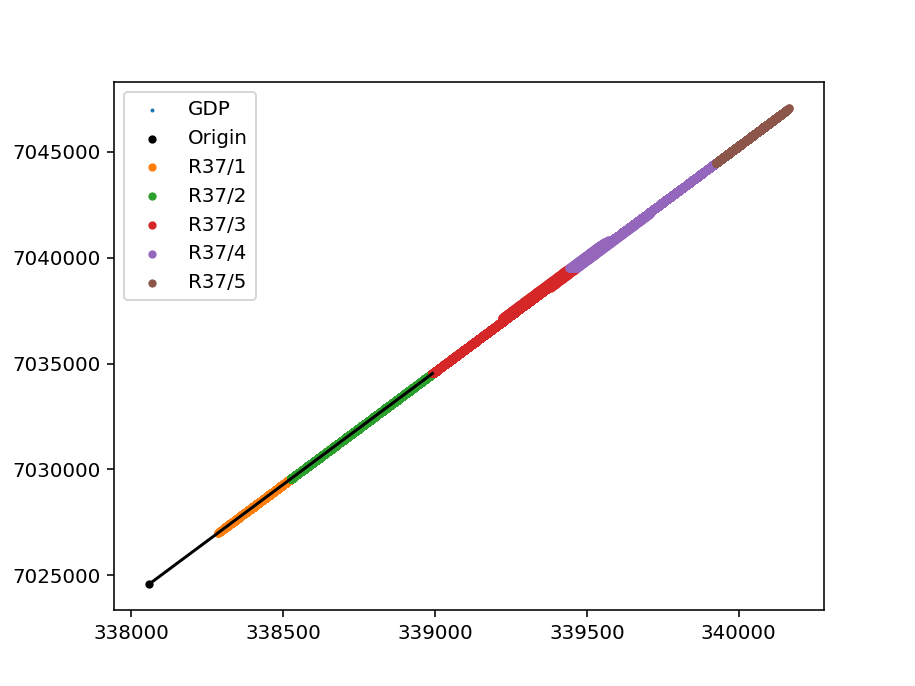

In [40]:
%matplotlib notebook

plt.scatter(mp37_index._idf['x_m'], mp37_index._idf['y_m'], s=1, label="GDP")

for k, v in mp37_index.meta.items():
    if k == 'bin_size':
        continue
    phi = v['phi']
    w = l* np.array([np.cos(np.radians(phi)), np.sin(np.radians(phi))])
    plt.scatter(*v['origin'], s=10, color='black', label='Origin')
    plt.plot(*np.vstack([v['origin'], v['origin'] + w]).T, color='black')

for i in mp37_index._idf.index.levels[0]:
    view = mp37_index._idf.loc[i]
    plt.scatter(view['x_m'], view['y_m'], s=10, label=i)

plt.legend()
plt.show()

In [41]:
path = '/home/egor/Desktop/2D_Valyton/prof_37/segy/'
batch = (fset.next_batch(5)
        .load(path=path, fmt='segy', get_file_by_index=get_file_by_index, skip_channels=2)
        .to_2d())

<IPython.core.display.Javascript object>


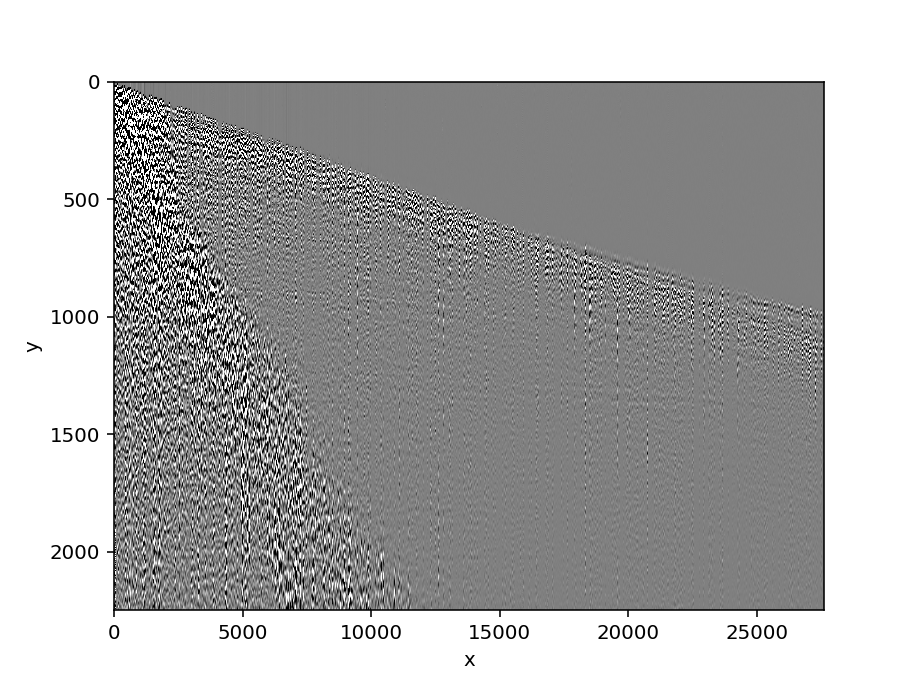

In [23]:
%matplotlib notebook
cv = 3
batch.show_slice('R37/1', vmin=-cv, vmax=cv, cmap="gray")

<IPython.core.display.Javascript object>


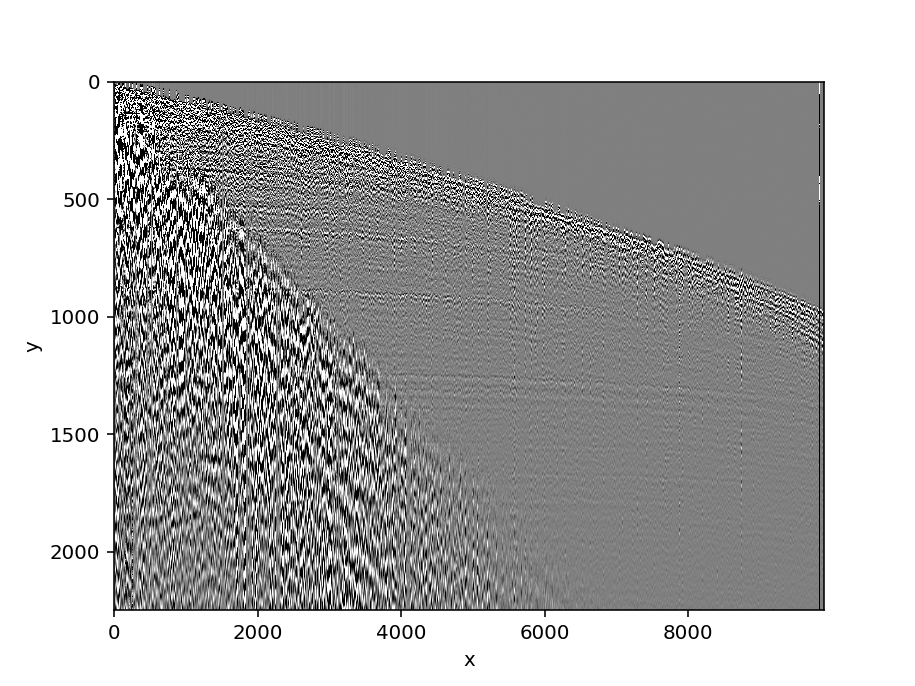

In [30]:
%matplotlib notebook
cv = 3
batch.show_slice('R37/5', vmin=-cv, vmax=cv, cmap="gray")